In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
%matplotlib inline

I was trying to find the dependency of the counts on the x-y position on the detector plane.
Given that the source is at (0,0,0), I want to fint the counts in a pixel at position (x,y,z).

$N_i=$ number of intercepted photons (counts)
$N_e=$ number of emitted photons

$N_i(x,y,z)=N_E(0,0,0) \frac{a  \cos{\theta}}{4 \pi (x^2 + y^2+ z^2)}$

where $\theta$ is the angle that the detector plane forms with the tangent plane of a sphere centered in the source position and with radius $(x^2 + y^2+ z^2)$.

 $\cos{\theta}=\frac{z}{\sqrt{x^2 + y^2+ z^2}}$

$$N_i(x,y,z)=N_E(0,0,0) \frac{a  z}{4 \pi (x^2 + y^2+ z^2)^{\frac{3}{2}}}$$
$$N_i(0,0,z)=N_E(0,0,0) \frac{a}{4 \pi z^{2}}$$

Therefore 
 
$\frac{N_i(x,y,z)}{N_i(0,0,z)}=\left(\frac{z}{\sqrt{x^2 + y^2+ z^2}}\right)^3$
$$ N_i(x,y,z)=N_i(0,0,z)\left(\frac{z}{\sqrt{x^2 + y^2+ z^2}}\right)^3 $$

In the function det_attenuation_profile I express the number of counts in a pixel at (x,y,120mm) position as a function of $\sqrt{x^2 + y^2}$, keeping $z$ fixed at the total detector-mask distance + source-mask distance 70mm +50mm = 120mm 

In [3]:

def det_attenuation_profile(x, c):
    sz=120
    return c*(np.divide(sz,np.sqrt((x**2)+(sz**2))))**3
    

def resample_array(array, n):
    a=array.repeat(n, axis=0)
    b=a.repeat(n, axis=1)
    return b

Read in the event list and convert the pixel values in mm 

In [4]:
eventlistfilepath="/Users/alex/Documents/simulations_pixelsize/random/sim_CsI_Wr31t1.0e2.5b0.0d50_X+00.00Y+00.00Z+07.00_10000flux/sim_CsI_Wr31t1.0e2.5b0.0d50_X+00.00Y+00.00Z+07.00_10000flux_FWHM2_0.050-0.050/mask00/"
eventlist='cutevents.csv'
x_source=float(eventlistfilepath[eventlistfilepath.find("X")+1:eventlistfilepath.find("X")+7])*10
y_source=float(eventlistfilepath[eventlistfilepath.find("Y")+1:eventlistfilepath.find("Y")+7])*10
z_source=float(eventlistfilepath[eventlistfilepath.find("Z")+1:eventlistfilepath.find("Z")+7])*10

source_pos=np.array((x_source, y_source))

print(source_pos)

eventlist=np.genfromtxt(eventlist, delimiter=",", skip_header=3)#this is gonna take a while...
eventlist=eventlist[:,[0,1,3]]

eventlist[:,0]=eventlist[:,0]*0.05#miltiply by the pixel size so x y values in eventlist are in mm
eventlist[:,1]=eventlist[:,1]*0.05

[0. 0.]


Rebin the shadowgram so pixels don't have only one or 2 counts per pixel and plot it

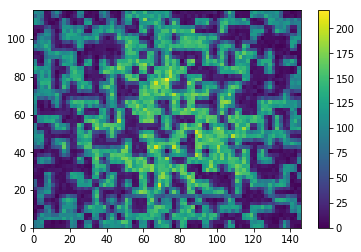

(145.75, 115.15)
(73.0, 58.0)


In [5]:
xpixels=2915*0.05#number of x pixels
ypixels=2303*0.05#number of y pixels
xbins=math.ceil(xpixels/2)
ybins=math.ceil(ypixels/2)

shadowgram,xedges,yedges,dummy=plt.hist2d(eventlist[:,0], eventlist[:,1], weights=eventlist[:,2], bins=(xbins, ybins))
plt.colorbar()
plt.show()

print(xpixels, ypixels)
print(xbins,ybins)


Create a matrix of distances of each pixel from the x,y position of the source. Each matrix element corresponds to a pixel and has the value $\sqrt{x^2+y^2}$

1.9965753424657535
73
1.985344827586207
58


Text(0.5,1,'$\\sqrt{x^2+y^2}$')

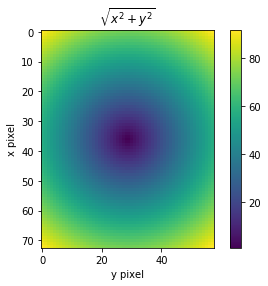

In [11]:
#Create a matrix of distances 
distance_matrix=np.zeros_like(shadowgram)
xbinsize=xedges[1]-xedges[0]
xbin_cen=(xedges[0:-1]+xbinsize*0.5)-(xpixels*0.5)
print(xbinsize)
print(len(xbin_cen))
#print(xbin_cen)

ybinsize=yedges[1]-yedges[0]
ybin_cen=(yedges[0:-1]+xbinsize*0.5)-(ypixels*0.5)

print(ybinsize)
print(len(ybin_cen))
#print(ybin_cen)

for i in range(len(xbin_cen)):
    for j in range(len(ybin_cen)):
        #distance_matrix[i][j]=np.linalg.norm(source_pos-np.array((xbin_cen[i], ybin_cen[j])))
        distance_matrix[i][j]=np.sqrt((xbin_cen[i]*xbin_cen[i])+(ybin_cen[j]*ybin_cen[j]))
                                      
plt.imshow(distance_matrix, aspect=1)
plt.colorbar()
plt.xlabel('y pixel')
plt.ylabel('x pixel')
plt.title('$\sqrt{x^2+y^2}$')
#print(shadowgram[1], xbin_cen)

Here I eliminate all the pixels with 0 counts and calculate the average of the values of the pixels with the distance in the same distance bin. for the error on the counts I apply a poissonian statistic, since the sum and average of poissonian statistics is still a scaled poissonian. 

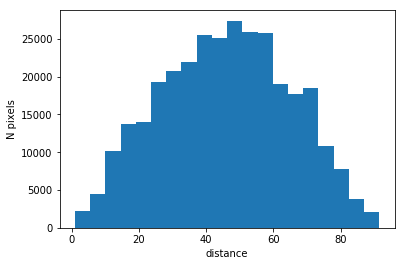

profile funcion coefficients:
[95.82141548]
Covariance of coefficients:
[[8.26662907]]


Text(0,0.5,'counts')

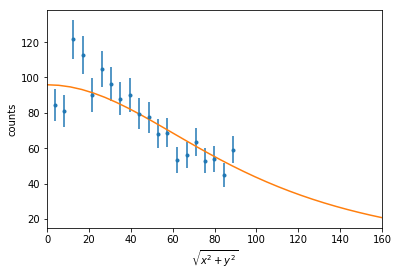

In [10]:
d=np.ravel(distance_matrix)
cts=np.ravel(shadowgram)

#d=d[cts>0]
#cts=cts[cts>0]


d_ave=[]
cts_ave=[]
cts_err=[]
distance_bins=plt.hist(d, weights=cts, bins=20)[1]

plt.xlabel("distance")
plt.ylabel("N pixels")
plt.show()
distance_bin_size=distance_bins[1]-distance_bins[0]
for d_bin in distance_bins[0:-1]:
    ind=np.where((d>d_bin) & (d<d_bin+distance_bin_size))
    d_ave.append(np.average(d[ind]))
    cts_ave.append(np.average(cts[ind]))
    cts_err.append(np.sqrt(np.average(cts[ind])))

    
param=[200]
param, param_cov = curve_fit(det_attenuation_profile, d_ave, cts_ave, p0=param, sigma=cts_err) 

print("profile funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

det_profile=det_attenuation_profile(np.linspace(0, 160, 30), param[0])

plt.errorbar(d_ave, cts_ave, yerr=cts_err, fmt= '.')
plt.plot(np.linspace(0, 160, 30), det_profile)

plt.xlim(0, 160)
plt.xlabel("$\sqrt{x^2+y^2}$")
plt.ylabel("counts")

here I create a matrix of the correction coefficients $C$. If
$$ N_i(x,y,z)=N_i(0,0,z)\left(\frac{z}{\sqrt{x^2 + y^2+ z^2}}\right)^3 $$,
$$ C= \left( \frac{z}{\sqrt{x^2 + y^2+ z^2}}\right)^3$$

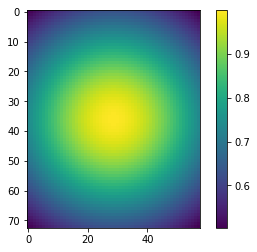

In [8]:
geom_eff=np.zeros(np.shape(shadowgram))
geom_eff=(det_attenuation_profile(distance_matrix, 1))
plt.imshow(geom_eff)
plt.colorbar()

To obtain the flattened shadowgram, i divide each pixel by the correction factor $C$

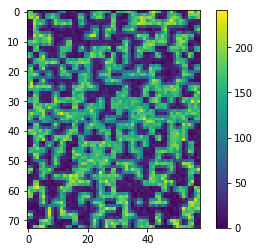

In [67]:
corr_shadowgram=np.divide(shadowgram, geom_eff)
plt.imshow(corr_shadowgram)
plt.colorbar()

To compare the two shadowgram, I plot the counts histograms for both. To me, it makes sense that the centre of the counts distribution coprresponds to the highest counts values of the non corrected one. 

Text(0,0.5,'# pixels')

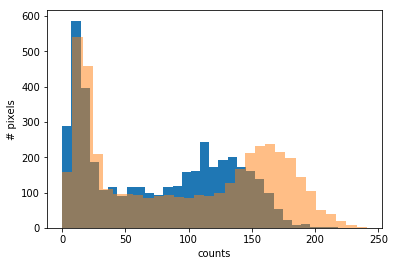

In [68]:
nbins=30
plt.subplot(1,1,1)
plt.hist(np.ravel(shadowgram), bins=nbins)
#plt.xlabel('counts')
#plt.ylabel('# pixels')
#plt.subplot(1,2,2)
plt.hist(np.ravel(corr_shadowgram), bins=nbins, alpha=0.5)
plt.xlabel('counts')
plt.ylabel('# pixels')

I also plot the number of counts as a function of the distrance from the centre. This shoud be constant if i corrected the shadowgram properly. I fit it with a line to check that the slope is almost consistant with 0. Should also try and fit it with a constant  

('m', -0.11160753433194955)
('p', 100.3962465446031)
('sigma_m', 0.10808929115810095)
('sigma_q', 5.809127778411739)


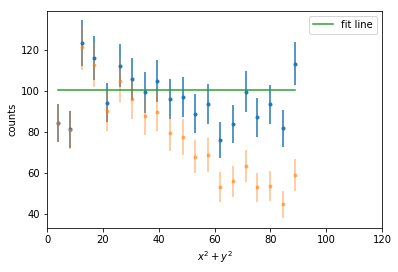

In [88]:
cts_ave_corr=[]
cts_err_corr=[]
cts_corr=np.ravel(corr_shadowgram)
for d_bin in distance_bins[0:-1]:
    ind=np.where((d>d_bin) & (d<d_bin+distance_bin_size))
    cts_ave_corr.append(np.average(cts_corr[ind]))
    cts_err_corr.append(np.sqrt(np.average(cts_corr[ind])))
    
    
    
p, v=np.polyfit(d_ave, cts_ave_corr, 1, cov=True, w=np.divide(1, cts_err_corr))
print('m', p[0])
print('p', p[1])

print('sigma_m', np.sqrt(v[0][0]))
print('sigma_q', np.sqrt(v[1][1]))


cts_fit=np.multiply([0],d_ave)+p[1]

plt.errorbar(d_ave, cts_ave_corr, yerr=cts_err_corr, fmt= '.')
plt.errorbar(d_ave, cts_ave, yerr=cts_err, fmt= '.', alpha=0.5)
plt.plot(d_ave, cts_fit, label='fit line')
plt.xlim(0, 120)
plt.xlabel("$x^2+y^2$")
plt.ylabel("counts")
plt.legend()

I also plot the profile of the corrected shadowgram vs the profile of the non corrected one. It seems overcorrected at the edge?

58


Text(0,0.5,'counts')

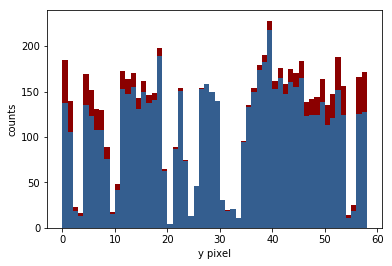

In [102]:
print(len(shadowgram[36]))
pixel=np.linspace(0, 58, 58)
plt.hist(pixel, weights=corr_shadowgram[36], bins=58, color='darkred')
plt.hist(pixel, weights=shadowgram[36], bins=58, alpha=0.8)
plt.xlabel('y pixel')
plt.ylabel('counts')

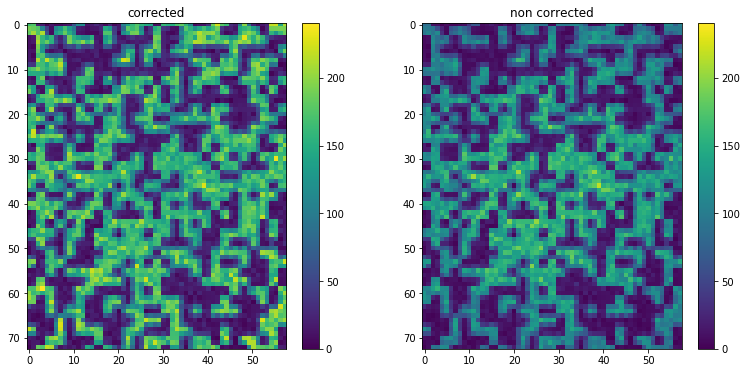

In [114]:

fig=plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
image1= plt.imshow(corr_shadowgram)
clim=image1.properties()['clim']
plt.title('corrected')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(shadowgram, clim=clim)
plt.title('non corrected')
plt.colorbar()


Here I am deconvolving the shadowgram to check if there is any difference between the corrected and uncorrected one.

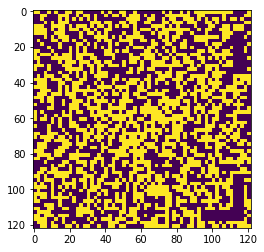

In [115]:
mask=(np.rot90(np.load("0_mask_pattern.npy")))

#The detector has a pixel size of 2mm so I need to oversample the mask the same way 
#2.5/2=1.25 

shadowgram_resampled=(resample_array(shadowgram, 1))
corr_shadowgram_resampled=(resample_array(corr_shadowgram, 1))
mask_resampled=resample_array(mask, 2)
plt.imshow(mask_resampled)


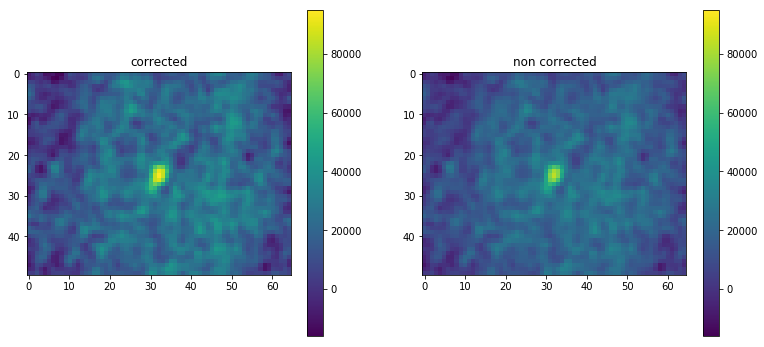

In [116]:
im=correlate2d(2*mask_resampled-np.ones((np.shape(mask_resampled))), shadowgram_resampled, mode='valid')
im_corr=correlate2d(2*mask_resampled-np.ones((np.shape(mask_resampled))), corr_shadowgram_resampled, mode='valid')

fig=plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
image1= plt.imshow(im_corr)
clim=image1.properties()['clim']
plt.title('corrected')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(im, clim=clim)
plt.title('non corrected')
plt.colorbar()
